## Overview

This notebook is an introduction to the theory and implementation of **p**ermutation **e**quivariant and **r**elative **m**argin  (**PERM**) losses and **involution codes**, which are mathematical frameworks for multiclass classification.

### Multiclass classification

We first review multiclass classification to set up notations.
Let $k \ge 2$ be an integer representing the number of classes and let $[k] = \{1,\dots, k\}$.
Let $d$ be a positive integer representing the number of features.
Given a labelled training dataset $\{(x_i,y_i) \in \mathbb{R}^d \times [k]\}_{i=1}^n$, we consider the problem of learning to classify a unseen unlabelled sample $x$ to a label $y \in \{1,\dots, k\}$, where $k \ge 2$.

One of the most popular approach is *empirical risk minimization* of solving the minimization
$$
\min_{f \in \mathcal{F}}
\quad
\mathtt{regularizer}(f)+
\sum_{i=1}^n L(y_i, f(x_i))
$$
where $L : [k] \times \mathbb{R}^k \to \mathbb{R}$ is a loss function and $\mathcal{F} := \{f : \mathbb{R}^d \to \mathbb{R}^k\}$ is a space of candidate functions.

### Cross entropy

The **cross entropy** is possibly one of the most widely used losses. It is also a great example to motivate PERM losses.

To introduce it, let us simplify notation and drop the index $i$ on $x_i$ and $y_i$. Furthermore, let $v := f(x_i)$. So the loss value $L(y_i, f(x_i))$ will be simply written as $L(y,v)$. Let $p \in \mathbb{R}^k$ be the softmax transformation of $v$, i.e.,

$$
p_i = \exp(v_i) \big/ \sum_{j=1}^k \exp(v_j).
$$

Then 
$$L(y, v) = -\ln(p_y) = \ln(1/p_y)  = \ln \left( 1+\sum_{j\in[k]: j\ne y} \exp( - (v_y - v_j)) \right).$$

Sometimes, the vector $v$ is referred to as *logits*. We will refer to them as **absolute margins** (since we will introduce their close cousin, the **relative margins**).

### PERM-ification of the cross entropy

For now, let $y =k$. Then

$$ L(k, v)  = \ln \left( 1+\sum_{j\in[k-1]} \exp( - (v_k - v_j)) \right). $$

Define $z \in \mathbb{R}^k$ such that $z_j := v_k - v_j$. Then the above can simply be written as
$$
L(k, v)  = \ln \left( 1+\sum_{j\in[k-1]} \exp( - z_j) \right).
$$

Let us define the function $\ell: \mathbb{R}^{k-1} \to \mathbb{R}$ by 
$$
\ell(z) :=  \ln \left( 1+\sum_{j\in[k-1]} \exp( - z_j) \right).$$

Then we have, by our definitions, that $\ell(z) = L(k,v)$. The function $\ell$ is the **PERM-ification** of the cross entropy (the terminology *PERM* will be explained shortly). Indeed, in our `losses.py`, we have

```
def cross_entropy(z):
    # Cross Entropy implemented in the PERM loss framework
    return K.log(1+K.sum(K.exp(-z),axis=1))
```

What about the values $L(y,v)$ where $y \ne k$? Enter the **involution code**.

### Involution code

Let $k$ be fixed. The involution code is the set of $k-1$-by-$k-1$ matrices $\rho_1,\dots, \rho_k$ defined as follows:
$\rho_k$ is the identity matrix. For $1\le j < k$,
$$
[\rho_j]_{s,t \in [k-1]} = \begin{cases} -1 &: j=t \\ 1 &: s=t,\, j\ne t\\ 0 &: \mbox{otherwise.} \end{cases}
$$

For example, when $k=4$, we have
$$
\rho_1 = \begin{bmatrix} -1 & 0 & 0 \\ -1 & 1 & 0 \\ -1 & 0 & 1\end{bmatrix} , \quad \rho_2 = \begin{bmatrix} 1 & -1 & 0 \\ 0 & -1 & 0 \\ 0 & -1 & 1\end{bmatrix} , \quad \rho_3 = \begin{bmatrix} 1 & 0 & -1 \\ 0 & 1 & -1 \\ 0 & 0 & -1\end{bmatrix} , \quad \rho_4 = \mathtt{eye}(3)
$$

One can easily check that 
$$
\ell(\rho_y z) = L(y,v)
$$
when $L$ is the cross entropy.

To summarize, we have the following **proto-Theorem**: the function $L : [k] \times \mathbb{R}^k \to \mathbb{R}$ can be equivalently represented by a smaller function $\ell : \mathbb{R}^{k-1} \to \mathbb{R}$ and the involution code $\{\rho_1,\dots, \rho_k\}$.

### Permutation equivariant and relative margin loss

Now, we consider an arbitrary multiclass loss $L : [k] \times \mathbb{R}^k \to \mathbb{R}$ (not just the cross entropy). The loss is said to be

1. **permutation equivariant** if for all bijections $\sigma : [k] \to [k]$, we have $L(\sigma(y), v) = L(y,\sigma(v))$
2. **relative margin**-based if the loss value $L(y,v)$ depends on $v$ only through $z = (v_k - v_1, v_k - v_2,\dots, v_k - v_{k-1})^\top$.

We now arrive at our theorem:

┌────────────────────

  **Theorem**: If a loss $L$ is permutation equivariant and relative margin-based (i.e., a PERM loss), then $L$ can be represented by some $\ell : \mathbb{R}^{k-1} \to \mathbb{R}$ where
$$\ell(\rho_y z) = L(y,v).$$

<div style="float: right"> ────────────────────┘</div> 


Other examples of PERM losses are the [Weston-Watkins](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.43.8167), [Crammer-Singer](https://jmlr.csail.mit.edu/papers/volume2/crammer01a/crammer01a.pdf) and [Duchi-Ruan-Khosravi](https://projecteuclid.org/journals/annals-of-statistics/volume-46/issue-6B/Multiclass-classification-information-divergence-and-surrogate-risk/10.1214/17-AOS1657.full) hinge losses.

The Weston-Watkins hinge loss:

$$
L_{WW}(y,v) = \sum_{j \in [k]: j \ne y} \mathtt{hinge}(v_y - v_j)
$$
and its corresponding $\ell$ function
$$
\ell_{WW}(z) = \sum_{j \in [k-1]} \mathtt{hinge}(z_j).
$$
Here $\mathtt{hinge}(t) = \max\{0, 1- t\}$ is the ordinary hinge function. The Crammer-Singer hinge loss is similar, where the $\sum$ is replaced by a $\max$.

The Duchi-Ruan-Khosravi hinge loss is more complicated and will not be discussed here.

### Binary classification and PERM losses

PERM losses and involution code seamlessly bridges binary and multiclass classification.
Note that when $k=2$, the involution code is simply 
$$\rho_1 = -1 \mbox{ and } \rho_2 = 1$$

The $\ell : \mathbb{R} \to \mathbb{R}$ function corresponding to the cross entropy reduces to simply
$$
\ell(z) = \ln(1+ \exp(-z)).
$$

The Weston-Watkins and Crammer-Singer hinge losses both reduce to just
$$
\ell_{WW}(z) = \ell_{CS}(z) = \mathtt{hinge}(z).
$$

As a sanity check, we check if our implementation does reflect this:

In [115]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

In [116]:
import tf_multiclass.losses as losses
import tf_multiclass.utils as utils
import tf_multiclass.metrics as metrics
import keras.backend as K
import tensorflow as tf
import numpy as np
from tf_multiclass.utils import to_t_categorical
import matplotlib.pyplot as plt

In [117]:
y_pred = tf.expand_dims(tf.linspace(-3.0,3.0,100),axis=-1)
y_true = to_t_categorical(np.ones((100,1)), num_classes=2)

In [118]:
ww = losses.WWHinge(reduction='none')(y_true,y_pred)
dkr = losses.DKRHinge(reduction='none')(y_true,y_pred)
ce = losses.CrossEntropy(reduction='none')(y_true,y_pred)

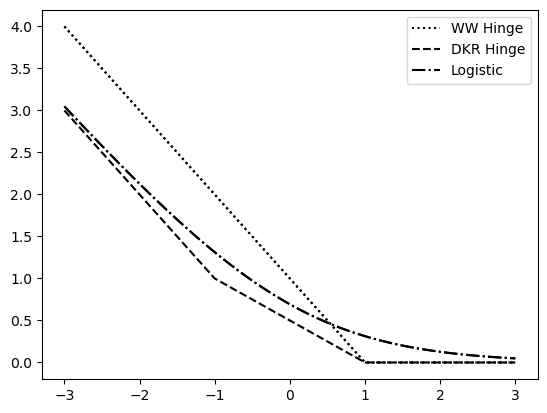

In [119]:
z = y_pred.numpy().squeeze()
plt.plot(z, ww.numpy(), "k:")
plt.plot(z, dkr.numpy(), "k--")
plt.plot(z, ce.numpy(), '-.k')
plt.plot(z, np.log(1+np.exp(-z)), "-.k")
plt.plot(z, np.maximum(0,1- z), 'k:')
plt.legend(['WW Hinge', 'DKR Hinge', 'Logistic'])
plt.show()

Note that the dotted (WW hinge) and the dot-dash (logistic) lines are each plotted twice but only appears once, indicating that they overlap perfectly. Thus, our implementation agrees with the theory.

### Computational issues

It appears that computing $\rho_y z$ requires a matrix-vector multiplication.
This could potentially be expensive when $k$ is large.
One approach to circumvent this might be to store $\rho_y$ as sparse matrices.
But there is an even easier approach, which we now demonstrate through an example.

When $k = 5$ and $y = 2$, we have
$$ 
\rho_2 = \begin{bmatrix} 1 &-1 & 0 & 0\\ 0 &-1 & 0 & 0\\ 0 &-1 & 1 & 0\\ 0 &-1 & 0 & 1\\ \end{bmatrix}$$

This can be rewritten as
$$ 
\rho_2= \begin{bmatrix} 1 &-1 & 0 & 0\\ 0 &-1 & 0 & 0\\ 0 &-1 & 1 & 0\\ 0 &-1 & 0 & 1\\ \end{bmatrix} = \begin{bmatrix} 1 &0 & 0 & 0\\ 0 &1 & 0 & 0\\ 0 &0 & 1 & 0\\ 0 &0 & 0 & 1\\ \end{bmatrix} - \begin{bmatrix} 0 &0 & 0 & 0\\ 0 &1 & 0 & 0\\ 0 &0 & 0 & 0\\ 0 &0 & 0 & 0\\ \end{bmatrix} - \begin{bmatrix} 0 &1 & 0 & 0\\ 0 &1 & 0 & 0\\ 0 &1 & 0 & 0\\ 0 &1 & 0 & 0\\ \end{bmatrix}
$$

Thus, 
$$ \rho_2 z = z - \begin{bmatrix} z_2 \\ z_2 \\ z_2 \\ z_2 \end{bmatrix} - \begin{bmatrix} 0\\z_2 \\ 0 \\ 0\end{bmatrix}$$

We now take a brief detour to introduce the **trimmed categorical** label encoding, a variation on the more popular *ordinary* categorical label encoding.

The ordinary categorical label encoding is also known as the *one-hot* encoding. The trimmed categorical encoding is simply the one-hot encoding where the last entry is omitted. For example, when $k=5$ and $y=2$, 

$$
\mathtt{to\_categorical}(2) = \begin{bmatrix} 0 & 1 & 0 &0 &0\end{bmatrix}^\top , \quad \mathtt{to\_trimmed\_categorical}(2) = \begin{bmatrix} 0 & 1 & 0 &0\end{bmatrix}^\top.
$$

The latter is implemented in `tf_multiclass.utils.to_t_categorical`.

In [120]:
utils.to_t_categorical([[1]], num_classes=5)

array([[0., 1., 0., 0.]], dtype=float32)

Note that by this definition, we have the seemingly odd situation that

$$
\mathtt{to\_categorical}(5) = \begin{bmatrix} 0 & 0 & 0 &0 &1\end{bmatrix}^\top , \quad \mathtt{to\_trimmed\_categorical}(5) = \begin{bmatrix} 0 & 0 & 0 &0\end{bmatrix}^\top.
$$

However, this is a feature, not a bug! This is because we now have the useful formula

$$\rho_y z = z - \mathtt{sum}(C) * \mathtt{ones} - C, \quad \mbox{ where }  C = z_y * \mathtt{to\_trimmed\_categorical}(y)$$

and $\mathtt{ones}$ is the all-ones vector of dimension $k-1$. 
Crucially, the above formula recovers $\rho_k z = z$.

The above formula is used by `tf_multiclass.losses.get_relative_margins` to compute $\rho_y z$.

Note that the inverse function $\mathtt{from\_trimmed\_categorical}$ can be implemented as

$$
y_{tcat} \mapsto \mathrm{argmax} ([y_{tcat}, 0.5])
$$

where $y_{tcat}$ is a trimmed categorical encoded label and $[y_{tcat}, 0.5]$ denotes padding by the constant $0.5$. This is implemented in `tf_multiclass.utils.from_t_categorical`.

In [121]:
y_raw = [[i] for i in range(5)]
y_enc = utils.to_t_categorical(y_raw, num_classes=5)
utils.from_t_categorical(y_enc)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 2., 3., 4.], dtype=float32)>

### Prediction function using relative margins

The prediction function with absolute margin is easy: it is simply $\mathrm{argmax}(v)$.
Now, recall that $z = [v_k - v_1, v_k - v_2,\dots, v_{k} - v_{k-1}]$.
Thus, if we pad $z$ with zero, we have
$$
[z,0] = [v_k - v_1, v_k - v_2,\dots, v_{k} - v_{k-1},0] = -v + v_k * \mathtt{ones}. $$
Thus, $\mathrm{argmax}(v) = \mathrm{argmin}([z,0])$ and the analog to the argmax is

$$
z \mapsto \mathrm{argmin}([z,0])
$$

This is implemented in `tf_multiclass.utils.predict_classes_from_r_margin`.

In [123]:
v = tf.random.uniform((2,5))
print("v =", v.numpy())
print("argmax v =", tf.argmax(v,axis=-1).numpy())
# z = v[0,-1] - v[0,:-1]
z = tf.expand_dims(v[:,-1],axis=-1) - v[:,:-1]

print("z =",z.numpy())
print("pred(z) =", utils.predict_classes_from_r_margin(z).numpy())

v = [[0.57523596 0.80402887 0.88161504 0.8814769  0.9216168 ]
 [0.07152212 0.78531957 0.9620981  0.11778855 0.69208217]]
argmax v = [4 2]
z = [[ 0.34638083  0.11758792  0.04000175  0.04013991]
 [ 0.62056005 -0.0932374  -0.27001595  0.5742936 ]]
pred(z) = [4. 2.]
